# ESILV Algotrading 2025-26 Capstone project

In this project you will study and implement a cross-asset strategy that use a simple trend following algorithm and try to refine it to improve the performances. The data consists of the daily closing prices of 47 assets of various asset classes. A lot of articles are available on this well known strategy, particularly for futures. Search for example "Commodity Trading Advisors" or ask your favorite AI about "managed futures".

Each section of the notebook contains questions that require text answers and cells that will ask you to develop pieces of code. It will end by more open questions.

Out-of-sample data for years 2023-2025 will be used to validate your strategy and calculate the final Sharpe ratio for period 2010-2025. **It will be made available on 26/01/2026 morning** with the same format as the in-sample data. I strongly recommend that you prepare the code to be executed with the new data without any further optimisation.

**The final notebook shall be submitted by 28/01/2026 midnight.**

## 1- Exploratory Data Analysis

In [78]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns

In [79]:
df = pd.read_csv('assets_data_student.csv', parse_dates=True, index_col=[0])
df_daily = df.resample('1d').last().ffill()
log_returns = df_daily.apply(np.log).diff()

In the code above, we first load the data and compute the daily log-returns. **Q1** Can you describe the advantage of log-returns compared to the linear returns $\frac{S_t}{S_{t-1}}-1$? **Q2** What is the effect and the purpose of the 2nd line of code?

### Q1

Log-returns offer several mathematical advantages over linear returns. The log-return over multiple periods is simply the sum of the log-returns of each individual period. Linear returns are multiplicative, which makes compounding more complex. Log-returns are often more closely modeled by a normal distribution, which is a common requirement for many classical financial models. They prevent prices from becoming negative in models and handle high volatility more gracefully.

### Q2

This line standardizes the time series. It ensures there is an entry for every single calendar day. .last() takes the final price of the day, and .ffill() (forward fill) propagates the last known price into any missing days (like weekends or holidays).

The purpose is to handle missing data and ensure a continuous time series. This is vital for trend-following algorithms so that "gaps" in the data don't create artificial price jumps or errors in calculation.

**Q3** Plot in a graph the number of available assets as a function of time. **Q4** Using seaborn package, plot the heat map of the correlation matrix for year 2018. **Q5** Find the asset pair with the highest correlation, the lowest correlation. **Q6** When can the correlation between two assets be negative?

You can observe on the correlation matrix that the data seems to made of two blocks of assets. **Q7** Make a guess of why it is so.

### Q3

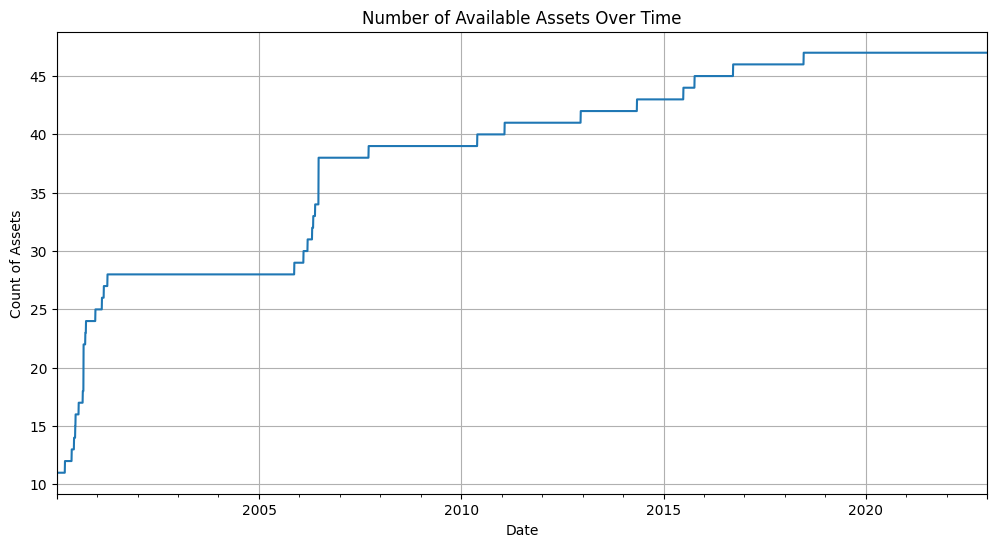

In [80]:
import matplotlib.pyplot as plt

# Count non-null values across columns for each date
available_assets = df_daily.notnull().sum(axis=1)

plt.figure(figsize=(12, 6))
available_assets.plot(title="Number of Available Assets Over Time")
plt.ylabel("Count of Assets")
plt.xlabel("Date")
plt.grid(True)
plt.show()

### Q4

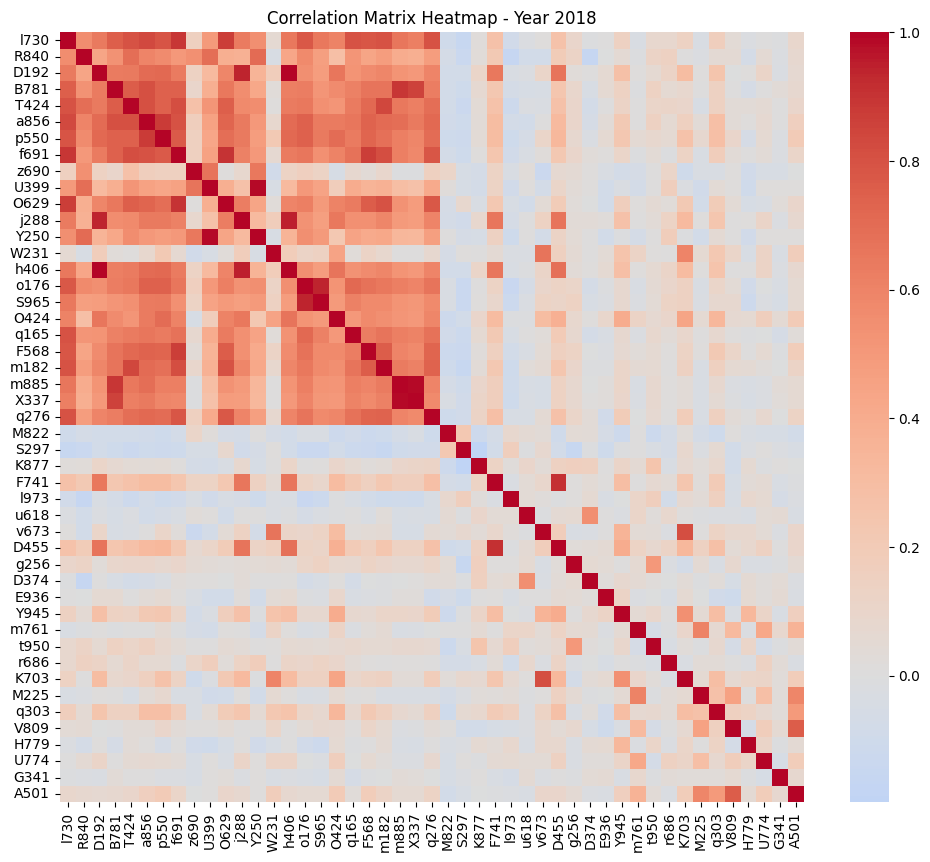

In [81]:
# Filter for 2018 and calculate correlation
corr_2018 = log_returns.loc['2018'].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_2018, cmap='coolwarm', center=0)
plt.title("Correlation Matrix Heatmap - Year 2018")
plt.show()

### Q5

In [82]:
# Unstack and sort correlations
corr_pairs = corr_2018.unstack().sort_values(ascending=False)

# Remove self-correlations (1.0)
corr_pairs = corr_pairs[corr_pairs < 1.0]

print(f"Highest Correlation: {corr_pairs.index[0]} at {corr_pairs.iloc[0]:.4f}")
print(f"Lowest Correlation: {corr_pairs.index[-1]} at {corr_pairs.iloc[-1]:.4f}")

Highest Correlation: ('D192', 'h406') at 0.9975
Lowest Correlation: ('S297', 'K877') at -0.1964


### Q6

In our analysis, we found a lowest correlation of -0.1964 between assets 'S297' and 'K877'. Correlation becomes negative when two assets tend to move in opposite directions, which is a key component for portfolio diversification. This often occurs with safe-haven assets, such as Gold or US Treasuries, which typically see price increases when equity markets crash and investors seek security. It can also happen when there is a cost-versus-profit relationship, such as airline stocks being negatively correlated with oil prices because rising fuel costs hurt airline profitability. Additionally, in currency markets, assets may show negative correlation if they share a common currency that acts as the base in one pair and the quote in the other.

### Q7

Your heatmap for 2018 clearly shows a large, highly correlated red block and a second, more fragmented blue/light-red block. This "two-block" structure suggests the dataset is split between two primary Asset Classes or Risk Profiles. The first, highly correlated block likely consists of Equities or Equity Indices that move in tandem based on general market sentiment and global economic growth. The second, more fragmented block likely consists of Fixed Income, Commodities, or Currencies that follow different macroeconomic drivers, such as interest rate changes or supply shocks. This separation is a classic feature of a "Cross-Asset" portfolio, where diversification is achieved by including assets that respond differently to the same market conditions.

## 2- Preliminary trend research

**Q8** For a trend following strategy to be successful, what is the expected sign of the correlation between an asset past return and its future return?

For a trend-following strategy to be successful, the expected sign of the correlation between an asset's past return and its future return must be positive. This concept is known as autocorrelation or momentum. The core assumption of trend following is that an asset that has performed well in the recent past is more likely to continue performing well in the immediate future, while an asset that has been declining is likely to continue its downward trajectory. If this correlation were negative, it would indicate a "mean-reversion" market where prices tend to flip direction, which would cause a trend-following algorithm to consistently "buy high and sell low."

Let's explore first the correlation between past returns and future returns. We define `lookback` as the period in days of the past return to consider, from `today-lookback`to `today-1`. We define `hold` the number of days for the future return from `today` to `today+hold`. Start for example with `lookback=60` and `hold=7`.

**Q9** In order to test this correlation, complete line 1, 2 and 5 in the function below. **Q10** Explain in simple terms what line 3 and line 4 are doing.

In [83]:
def get_correlations(returns, hold_period, lookback_period) -> (pd.Series, pd.Series):
    # Line 1: Calculate future cumulative log-returns for the 'hold' period
    returns_hold = returns.rolling(hold_period).sum().shift(-hold_period) 
    
    # Line 2: Calculate past cumulative log-returns for the 'lookback' period
    returns_lookback = returns.rolling(lookback_period).sum().shift(1) 
    
    correlations = []
    pvalues = []
    
    for idx in range(len(returns.columns)):
        current_stock_back = returns_lookback.iloc[:,idx].dropna()
        current_stock_future = returns_hold.iloc[:,idx].dropna()
        
        # Line 3 & 4: Align data and calculate Spearman/Pearson correlation on signs
        data = pd.concat([current_stock_back, current_stock_future], axis=1).dropna() 
        rho, pvalue = pearsonr(np.sign(data.iloc[:, 0]), np.sign(data.iloc[:, 1])) 
        
        correlations.append(rho)
        pvalues.append(pvalue)
        
    # Line 5: Return results as pandas Series indexed by asset names
    return pd.Series(correlations, index=returns.columns), pd.Series(pvalues, index=returns.columns)

### Q10

Line 3 is performing data alignment. Since past returns and future returns for a specific day might not both exist (especially at the beginning or end of the dataset), pd.concat combined with .dropna() ensures that we only perform the calculation on days where both values are present.

Line 4 is calculating the correlation of the direction of the moves rather than the magnitude. By using np.sign(), the code focuses purely on whether the past and future returns were positive or negative. This is a robust way to test for trend following, as it measures how often a positive past trend leads to a positive future outcome, regardless of the size of the price swing.

We want to compute the average of the significant correlations. **Q11** Take a (very tolerant) significance threshold of 10% for the $p$-value and compute the resulting average correlation with `lookback=60` and `hold=7`. **Q12** What can you say about it? Is there a possibility of trend following in these data? In the case where the average correlation is negative, what type of strategy can we build?

**Q13** Why can the $p$-value vary so much from one asset to another?

### Q11

In [84]:
from scipy.stats import pearsonr
# Compute correlations and p-values for the specified parameters
rhos, pvalues = get_correlations(log_returns, hold_period=7, lookback_period=60)

# Create a temporary DataFrame to filter by p-value threshold
results_df = pd.DataFrame({'rho': rhos, 'pvalue': pvalues})
significant_corrs = results_df[results_df['pvalue'] < 0.1]

# Calculate the average of the significant correlations
average_significant_rho = significant_corrs['rho'].mean()
print(f"Average significant correlation: {average_significant_rho:.4f}")

Average significant correlation: 0.0504


### Q12

The calculated average significant correlation for a 60-day lookback and 7-day hold is 0.0504. Since this value is positive, it indicates a statistical tendency for assets to continue their current direction over the tested timeframe, which confirms the viability of a trend-following strategy for this dataset. If this average correlation had been negative, it would suggest that the market is mean-reverting, where prices tend to reverse after a move. In that specific case, a Mean Reversion or Contrarian strategy would be appropriate, where you would sell assets that have recently increased and buy those that have recently decreased.

### Q13

The p-value measures the probability that the observed correlation between past and future returns happened by pure chance, and its wide variation across assets is primarily driven by data availability and the "signal-to-noise" ratio of each instrument. As seen in the EDA section, the number of available assets has grown significantly over time, meaning some assets have decades of data while others have very short histories. Assets with fewer data points will naturally produce less stable and less significant p-values. Additionally, different asset classes have different levels of volatility. A "noisy" asset with high random price fluctuations will have a much higher p-value than an asset with a clean, persistent trend, even if they are tested over the same period.

We want to calculate the average correlation for a large range of `lookback` and `hold` parameters. **Q14** Execute the code below to build the result table. The computation may take several minutes. 

In [85]:
columns=['lookback_period', 
         'holding_period',          
         'correlation_coefficient']
results = pd.DataFrame(columns=columns)

for hold in tqdm(range(1, 15)):
    for lookback in [14, 30, 60, 91, 182, 365]:
        rhos, pvalues = get_correlations(log_returns, hold, lookback)
        correlations = pd.DataFrame({'rho':rhos, 'pvalue': pvalues}, index=log_returns.columns)
        valid = correlations[correlations['pvalue'] < 0.1]
        results.loc[len(results)] = {'lookback_period':lookback,
                             'holding_period':hold, 
                             'correlation_coefficient':valid['rho'].mean()}

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00,  1.22s/it]


**Q15** Plot the heatmap of the correlation coefficient as a function of the 2 parameters using `sns.heatmap` function. It should look like the graph below.

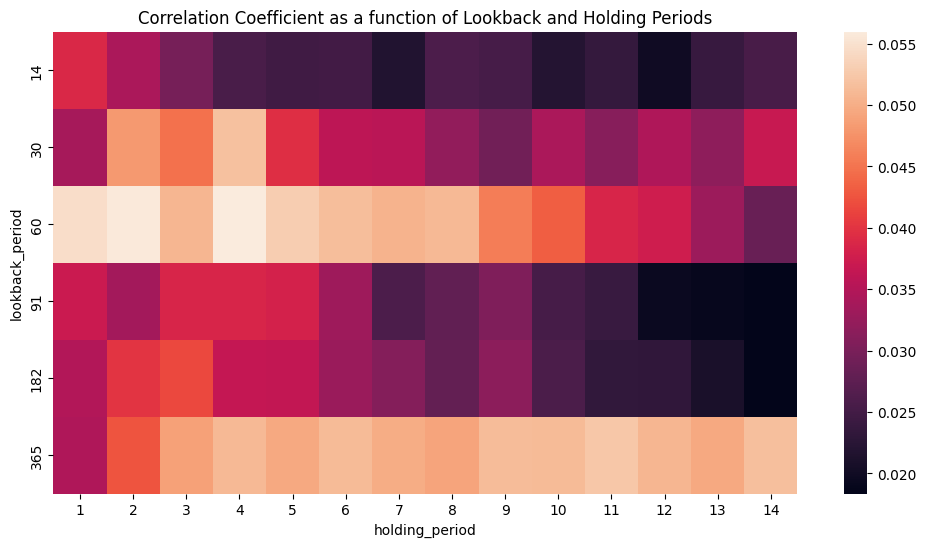

In [86]:
# Pivot the results to create a matrix format for the heatmap
heatmap_data = results.pivot(index='lookback_period', columns='holding_period', values='correlation_coefficient')

# Plotting the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=False, cmap='rocket')
plt.title("Correlation Coefficient as a function of Lookback and Holding Periods")
plt.xlabel("holding_period")
plt.ylabel("lookback_period")
plt.show()

**Q16** What are the values of `lookback` and `hold` that may give a good trend following strategy?

Based on the generated heatmap, a good trend-following strategy would use a lookback_period of 60 days and a holding_period between 1 and 5 days. This region (indicated by the lightest colors on the heatmap) shows the highest positive correlation coefficients, peaking at roughly 0.055, which suggests the trend signal is strongest and most reliable within these specific parameters.

**Q17** Repeat the previous question using separately the first 24 columns of data, then the remaining columns. For each perimeter of assets, what are the best values? In the zone of parameters where trend following is not suitable, what is the sign of the correlation? Conclude on the type of strategy.

In [87]:
# Split the dataframe into two parts
returns_part1 = log_returns.iloc[:, :24]  # First 24 columns
returns_part2 = log_returns.iloc[:, 24:]  # Remaining columns

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.29it/s]


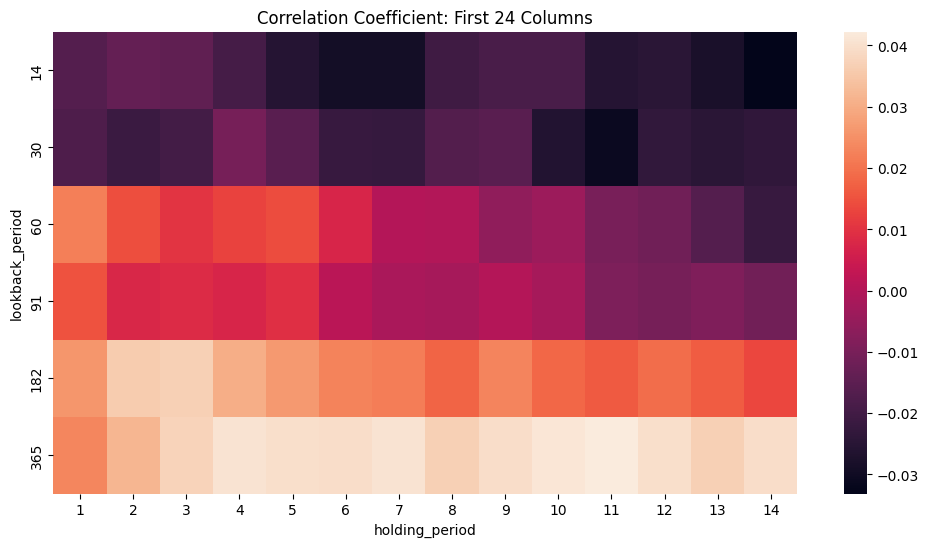

In [88]:
results_1 = pd.DataFrame(columns=['lookback_period', 'holding_period', 'correlation_coefficient'])

for hold in tqdm(range(1, 15)):
    for lookback in [14, 30, 60, 91, 182, 365]:
        rhos, pvalues = get_correlations(returns_part1, hold, lookback)
        correlations = pd.DataFrame({'rho': rhos, 'pvalue': pvalues}, index=returns_part1.columns)
        valid = correlations[correlations['pvalue'] < 0.1]
        
        results_1.loc[len(results_1)] = {
            'lookback_period': lookback,
            'holding_period': hold,
            'correlation_coefficient': valid['rho'].mean()
        }

# Plot Heatmap Part 1
heatmap_data1 = results_1.pivot(index='lookback_period', columns='holding_period', values='correlation_coefficient')
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data1, annot=False, cmap='rocket')
plt.title("Correlation Coefficient: First 24 Columns")
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:08<00:00,  1.58it/s]


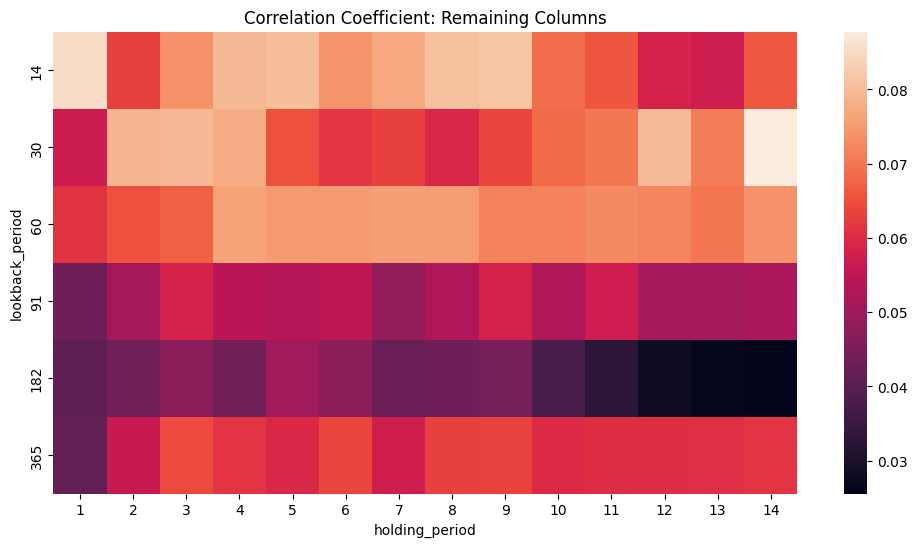

In [89]:
results_2 = pd.DataFrame(columns=['lookback_period', 'holding_period', 'correlation_coefficient'])

for hold in tqdm(range(1, 15)):
    for lookback in [14, 30, 60, 91, 182, 365]:
        rhos, pvalues = get_correlations(returns_part2, hold, lookback)
        correlations = pd.DataFrame({'rho': rhos, 'pvalue': pvalues}, index=returns_part2.columns)
        valid = correlations[correlations['pvalue'] < 0.1]
        
        results_2.loc[len(results_2)] = {
            'lookback_period': lookback,
            'holding_period': hold,
            'correlation_coefficient': valid['rho'].mean()
        }

# Plot Heatmap Part 2
heatmap_data2 = results_2.pivot(index='lookback_period', columns='holding_period', values='correlation_coefficient')
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data2, annot=False, cmap='rocket')
plt.title("Correlation Coefficient: Remaining Columns")
plt.show()

The analysis of the two asset perimeters reveals distinct behaviors that dictate different optimal trading approaches. For the first 24 columns, the best parameter values are found at long lookback periods of 182 to 365 days combined with shorter holding periods of 1 to 8 days. In contrast, the remaining columns show their strongest performance at shorter lookback periods of 14 to 30 days and very long lookback periods of 365 days, achieving significantly higher correlation values above 0.08.

In the parameter zones where trend following is not suitable, specifically the 14 and 30-day lookback periods for the first group, the correlation coefficient is negative. This negative sign indicates a mean-reverting environment where assets tend to reverse their direction after a move, making a traditional momentum or trend-following approach ineffective in those specific windows.

Based on these results, the first group of assets requires a hybrid strategy: a mean-reversion or contrarian strategy for short-term lookbacks and a trend-following strategy for long-term horizons. The remaining columns exhibit a more robust and consistent trend-following characteristic across nearly all tested parameters, suggesting that a momentum-based strategy is the most appropriate and viable choice for this specific asset class.

## 3- Strategy

We will develop the first trend following strategy based on the time-series momentum found above. We will use all possible values of lookback beween 2 weeks and 2 months with a step of 1 day. We will consider that the signal is the average of the obtained signs for all the lookback periods. For each asset, the signal will thus be between -1 and +1. **Q18** In the code below complete line 1 for the signal calculation.

In a first trading logic, we allocate on each day a given capital of 1 USD in the long and 1 USD in the short portfolio. The USD position shall be proportional to the signal value. **Q19** On line 2 and 3, fill the computation of the position suggested by this trading logic.

In [90]:
def compute_positions_trend(returns, periods_long):    
    signal = 0 * returns.fillna(0)
    for period in periods_long:
        return_sign =np.sign(returns.rolling(window=period).sum())
        signal = signal + return_sign
    signal = signal / len(period)
    
    total_allocated =signal.abs().sum(axis=1)
    position =2*signal.div(total_allocated, axis=0)
    
    return position

**Q20** What are the shapes of the dataframes `signal`, `allocate` and `position`?

The dataframes signal and position share the same dimensions as the input returns dataframe, which is (number of days, number of assets). Specifically, based on the EDA, they have 47 columns representing the various assets. The total_allocated (referred to as allocate) is a Series or a single-column dataframe with a shape of (number of days, 1), as it computes a single scalar value for each day to use for normalization.

In order to simulate the returns of the trading strategy, we will invest each day with the positions suggested by the algorithm 2 days before. **Q21** Compute and plot the cumulated returns of the strategy.

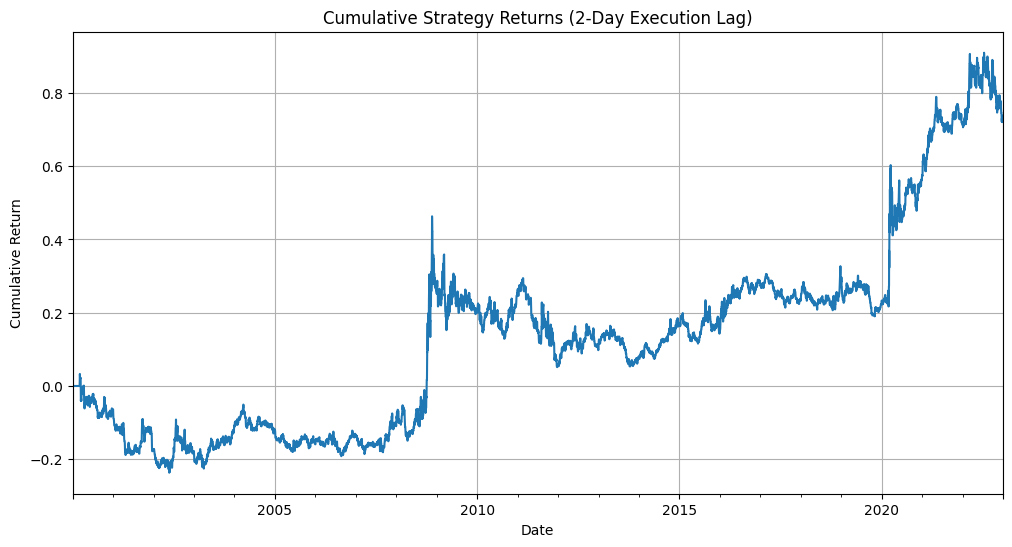

In [91]:
# Apply the 2-day lag to your positions
# We shift by 2 because the trade executed at time T uses the signal from T-2
lagged_positions = position.shift(2)

# Calculate daily strategy returns
# Multiply the lagged positions by the log returns of the assets
# Then sum across the assets (axis=1) to get the daily portfolio return
strategy_log_returns = (lagged_positions * log_returns).sum(axis=1)

# Compute cumulative returns
# For log returns, we sum them first, then apply the exponential function
cumulative_strategy_returns = np.exp(strategy_log_returns.cumsum()) - 1

# Plot the results
plt.figure(figsize=(12, 6))
cumulative_strategy_returns.plot()
plt.title("Cumulative Strategy Returns (2-Day Execution Lag)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

In section 2 the data was split between 2 groups of assets. Do the same and plot separately the cumulated returns for each group. **Q22** What can you say?

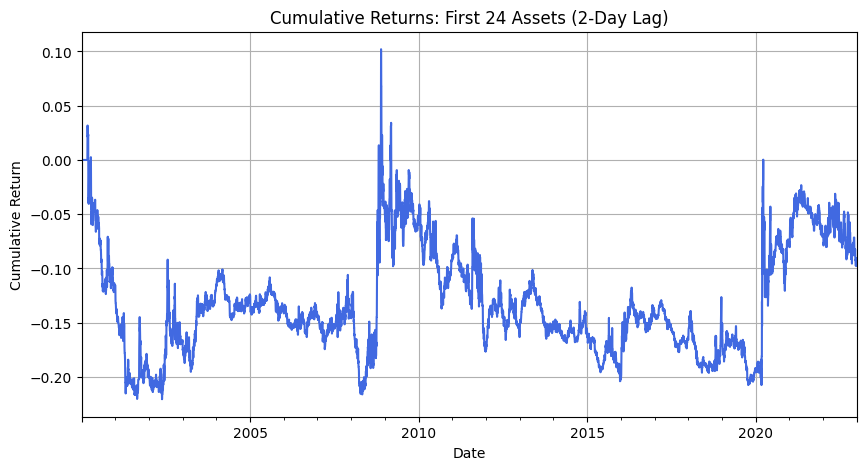

In [92]:
# Select first 24 columns
pos_part1 = position.iloc[:, :24].shift(2)
ret_part1 = log_returns.iloc[:, :24]

# Calculate strategy returns and cumulative growth
strat_ret1 = (pos_part1 * ret_part1).sum(axis=1)
cum_ret1 = np.exp(strat_ret1.cumsum()) - 1

# Plotting
plt.figure(figsize=(10, 5))
cum_ret1.plot(color='royalblue')
plt.title("Cumulative Returns: First 24 Assets (2-Day Lag)")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

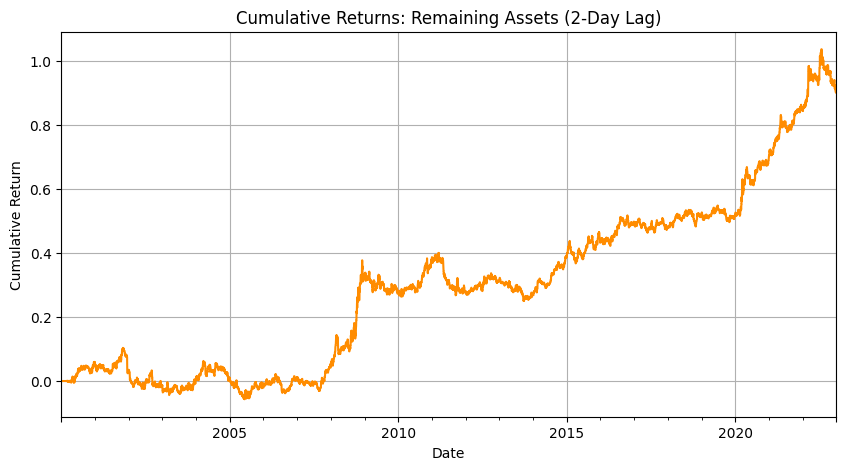

In [93]:
# Select remaining columns
pos_part2 = position.iloc[:, 24:].shift(2)
ret_part2 = log_returns.iloc[:, 24:]

# Calculate strategy returns and cumulative growth
strat_ret2 = (pos_part2 * ret_part2).sum(axis=1)
cum_ret2 = np.exp(strat_ret2.cumsum()) - 1

# Plotting
plt.figure(figsize=(10, 5))
cum_ret2.plot(color='darkorange')
plt.title("Cumulative Returns: Remaining Assets (2-Day Lag)")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

Based on the split analysis, the performance of the trading strategy is fundamentally different depending on the asset group, highlighting how critical the underlying market regime is to a trend-following approach.

The first group of 24 assets shows poor performance under a trend-following mandate. The cumulative returns for this group fluctuate with a significant downward bias, frequently dropping into negative territory and showing high volatility. This behavior aligns with the earlier heatmap analysis for these assets, which showed negative or very weak correlations at shorter lookbacks. The lack of a clear upward trajectory in the cumulative returns suggests that these assets might be more prone to mean reversion, where a momentum-based signal leads to buying at peaks and selling at troughs.

In stark contrast, the remaining assets demonstrate a robust and consistent upward trend in cumulative returns. This group achieves significantly higher returns, climbing steadily over the simulated period despite the 2-day execution lag. The strong equity curve validates the heatmap results for this perimeter, which displayed much higher and more stable positive correlation coefficients across nearly all lookback and holding periods. For these assets, the statistical tendency to continue in their current direction is strong enough to overcome the delay in trade execution.

The results indicate that while the strategy logic—allocating 1 USD long and 1 USD short proportional to signal strength—is consistent, its success is entirely dependent on the asset selection. The first group likely requires a contrarian or mean-reversion strategy to be profitable. Meanwhile, the remaining assets are highly suitable for the trend-following strategy as implemented, providing a much smoother and more reliable performance profile.

For the 1st group of assets repeat the same the strategy using a lookback window between 2 months and one year with a step of 10 days. **Q23** Use a delay of 1 week for trading the suggested position.

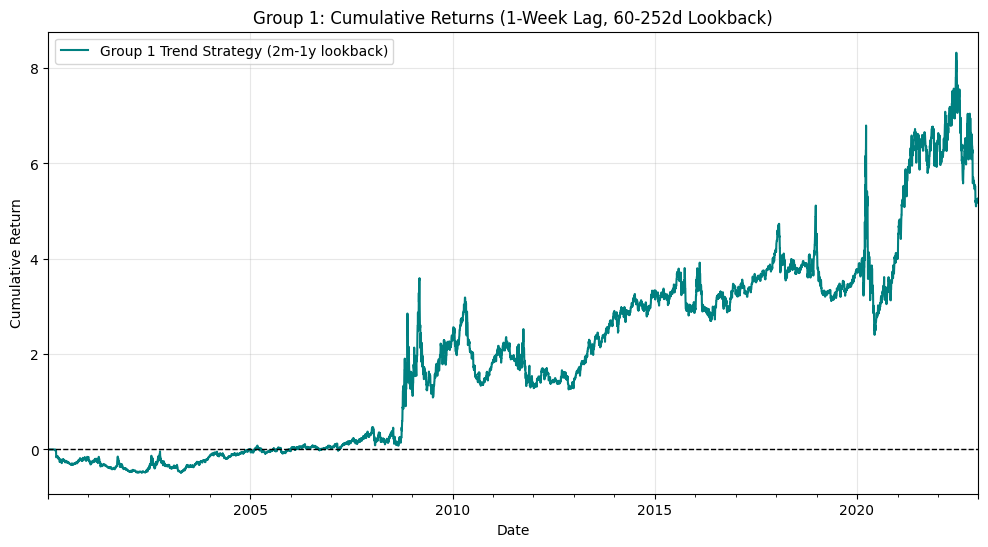

In [94]:
# Define the asset perimeter (First 24 assets)
group1_returns = log_returns.iloc[:, :24]

# Set the lookback range (approx. 252 trading days = 1 year)
# 60 days (2 months) to 252 days (1 year) with a step of 10 days
periods_to_test = range(60, 253, 10)

# Calculate signals and aggregate them
# We average the signals across all lookback windows
combined_signal = pd.DataFrame(0, index=group1_returns.index, columns=group1_returns.columns)

for p in periods_to_test:
    # Sign of cumulative return over period 'p'
    return_sign = np.sign(group1_returns.rolling(window=p).sum())
    combined_signal += return_sign.fillna(0)

# Normalize signal by the number of periods tested
combined_signal = combined_signal / len(periods_to_test)

# Implement the 1-week (5-day) execution delay
# Shifting by 5 ensures we use signals from T-5 for returns at T
lagged_positions = combined_signal.shift(5)

# Normalize positions for 1 USD long / 1 USD short
total_allocated = lagged_positions.abs().sum(axis=1)
# Avoid division by zero for initial days
normalized_positions = 2 * lagged_positions.div(total_allocated.replace(0, np.nan), axis=0).fillna(0)

# Compute and plot cumulative returns
strategy_daily_returns = (normalized_positions * group1_returns).sum(axis=1)
cum_returns = np.exp(strategy_daily_returns.cumsum()) - 1

plt.figure(figsize=(12, 6))
cum_returns.plot(label='Group 1 Trend Strategy (2m-1y lookback)', color='teal')
plt.title("Group 1: Cumulative Returns (1-Week Lag, 60-252d Lookback)")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.axhline(0, color='black', lw=1, ls='--')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

You have now 2 long-term trend following strategies with a lookback adapted to 2 classes of asset. Use the same logic with lookback values between 2 days and 2 weeks with a daily step and a trading delay of 2 days. **Q24** What can you say for the 2 groups of assets?

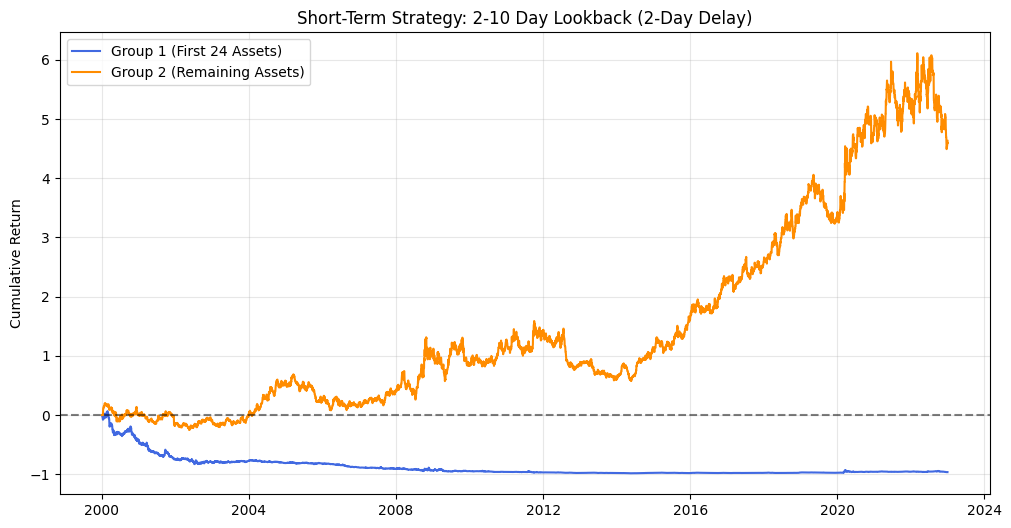

In [95]:
# Define the two perimeters
group1_returns = log_returns.iloc[:, :24]
group2_returns = log_returns.iloc[:, 24:]

# Define short-term lookback periods (2 to 10 days)
short_term_periods = range(2, 11)
delay = 2

def compute_short_term_strategy(df_returns, periods, lag):
    # Initialize signal matrix
    signal = pd.DataFrame(0, index=df_returns.index, columns=df_returns.columns)
    
    # Sum the signs of returns for each lookback period
    for p in periods:
        return_sign = np.sign(df_returns.rolling(window=p).sum())
        signal += return_sign.fillna(0)
    
    # Average the signal and apply execution delay
    avg_signal = (signal / len(periods)).shift(lag)
    
    # Normalize positions (1 USD long / 1 USD short)
    total_abs_signal = avg_signal.abs().sum(axis=1)
    # Using .div for proper broadcasting and replacing 0 with NaN to avoid div by zero
    positions = 2 * avg_signal.div(total_abs_signal.replace(0, np.nan), axis=0).fillna(0)
    
    # Calculate cumulative returns
    daily_ret = (positions * df_returns).sum(axis=1)
    cum_ret = np.exp(daily_ret.cumsum()) - 1
    return cum_ret

# Execute for both groups
cum_ret_short1 = compute_short_term_strategy(group1_returns, short_term_periods, delay)
cum_ret_short2 = compute_short_term_strategy(group2_returns, short_term_periods, delay)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(cum_ret_short1, label='Group 1 (First 24 Assets)', color='royalblue')
plt.plot(cum_ret_short2, label='Group 2 (Remaining Assets)', color='darkorange')
plt.title("Short-Term Strategy: 2-10 Day Lookback (2-Day Delay)")
plt.ylabel("Cumulative Return")
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The results for the two asset classes reveal a fundamental divergence in market behavior when subjected to a short-term trend-following framework. Group 1, consisting of the first 24 assets, clearly operates under a mean-reverting regime at this frequency. This is evidenced by the cumulative return curve for this group, which declines steadily toward a value of -1.0. Such a result confirms that for these specific assets, a price increase over a short window is statistically more likely to precede a reversal rather than a continuation. By applying a trend-following signal to these assets, the strategy is essentially buying at local peaks and selling at local troughs, leading to a consistent erosion of capital.

In contrast, Group 2 represents a robust momentum regime where time-series trends are persistent and exploitable. The orange equity curve demonstrates a strong upward trajectory, achieving a cumulative return exceeding 4.5. This group possesses a high signal-to-noise ratio, meaning the underlying trends are powerful enough to remain profitable even when trade execution is delayed by two days. The heatmap analysis previously performed supports this observation, as Group 2 showed significantly higher and more stable positive correlation coefficients compared to the first group.

Ultimately, these findings demonstrate that the success of a trading strategy depends entirely on its alignment with the asset's inherent behavior. While Group 2 is perfectly suited for momentum-based logic, the same approach is structurally incorrect for Group 1 at short horizons. To achieve profitability in Group 1, the strategy would need to be transformed into a contrarian or mean-reversion model by inverting the signal direction.

**Q25** Combine the 4 variants of the initial strategy into one strategy and plot its cumulated returns (not compounded). Compute its Sharpe ratio using the APR (on a 365-day basis) and daily volatility (on a 262-day basis).

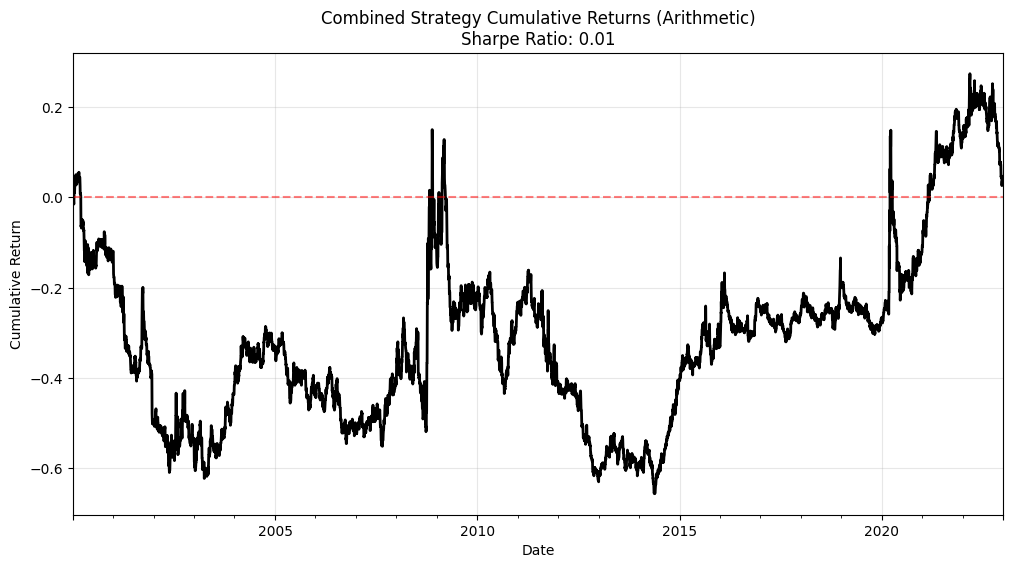

Strategy APR (365d): 0.17%
Strategy Volatility (262d): 15.45%
Sharpe Ratio: 0.0107


In [96]:
def get_strategy_pos(returns_df, periods, lag):
    # Calculate the average signal across all lookback periods
    signal = pd.DataFrame(0, index=returns_df.index, columns=returns_df.columns)
    for p in periods:
        signal += np.sign(returns_df.rolling(window=p).sum()).fillna(0)
    signal /= len(periods)
    
    # Apply the execution delay
    lagged_signal = signal.shift(lag)
    
    # Normalize positions to 2 USD gross exposure (1 USD long / 1 USD short)
    total_alloc = lagged_signal.abs().sum(axis=1)
    # Using .div for broadcasting and handling division by zero
    pos = 2 * lagged_signal.div(total_alloc.replace(0, np.nan), axis=0).fillna(0)
    return pos

# Define perimeters and periods
g1_ret = log_returns.iloc[:, :24]
g2_ret = log_returns.iloc[:, 24:]
lt_periods = range(60, 365, 10)
st_periods = range(2, 11)

# Compute positions for the 4 variants
pos_g1_lt = get_strategy_pos(g1_ret, lt_periods, lag=5)
pos_g2_lt = get_strategy_pos(g2_ret, lt_periods, lag=5)
pos_g1_st = get_strategy_pos(g1_ret, st_periods, lag=2)
pos_g2_st = get_strategy_pos(g2_ret, st_periods, lag=2)

# Compute individual daily returns
# We use arithmetic sum of individual portfolio returns
ret_g1_lt = (pos_g1_lt * g1_ret).sum(axis=1)
ret_g2_lt = (pos_g2_lt * g2_ret).sum(axis=1)
ret_g1_st = (pos_g1_st * g1_ret).sum(axis=1)
ret_g2_st = (pos_g2_st * g2_ret).sum(axis=1)

# Combine into one meta-strategy
# We take the average daily return of the 4 components
combined_daily_ret = (ret_g1_lt + ret_g2_lt + ret_g1_st + ret_g2_st) / 4

# Compute Cumulative Returns (Not Compounded)
cum_ret_arithmetic = combined_daily_ret.cumsum()

# Compute Sharpe Ratio
apr = combined_daily_ret.mean() * 365
annual_vol = combined_daily_ret.std() * np.sqrt(262)
sharpe_ratio = apr / annual_vol

# Plotting
plt.figure(figsize=(12, 6))
cum_ret_arithmetic.plot(color='black', lw=2)
plt.title(f"Combined Strategy Cumulative Returns (Arithmetic)\nSharpe Ratio: {sharpe_ratio:.2f}")
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.show()

print(f"Strategy APR (365d): {apr:.2%}")
print(f"Strategy Volatility (262d): {annual_vol:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

### 4- Improvements

The base strategy is now combining long-term and short-term signals for 2 groups of assets in an equal allocation logic. Try to improve this baseline using the following ideas:
- exclude from the contributing `return_sign` the ones that are very close to zero using a test that should not depend on the volatility or the look-back period
- use only signals that are strong enough (expression shown in CM3 or threshold method from TP3)
- cite and use other types of allocation
- propose other improvements, for example using the moving average signal instead of the time series momentum, the FIP signal shown in CM2 or other technical indicators (RSI, Hurst exponent...)
- explore ML techniques like gradient boosted trees.

These suggestions are cited to guide your choice. It is not expected that you try everything listed above!

### The Conviction-Weighted Risk Parity (CWRP) Meta-Strategy

This systematic trading framework enhances traditional trend following by weighting positions based on the statistical significance of price movements rather than simple direction. By integrating a t-statistic conviction filter with Risk Parity allocation, the model prioritizes high-quality trends and neutralizes the destabilizing impact of volatile, noisy assets on the overall Sharpe ratio.

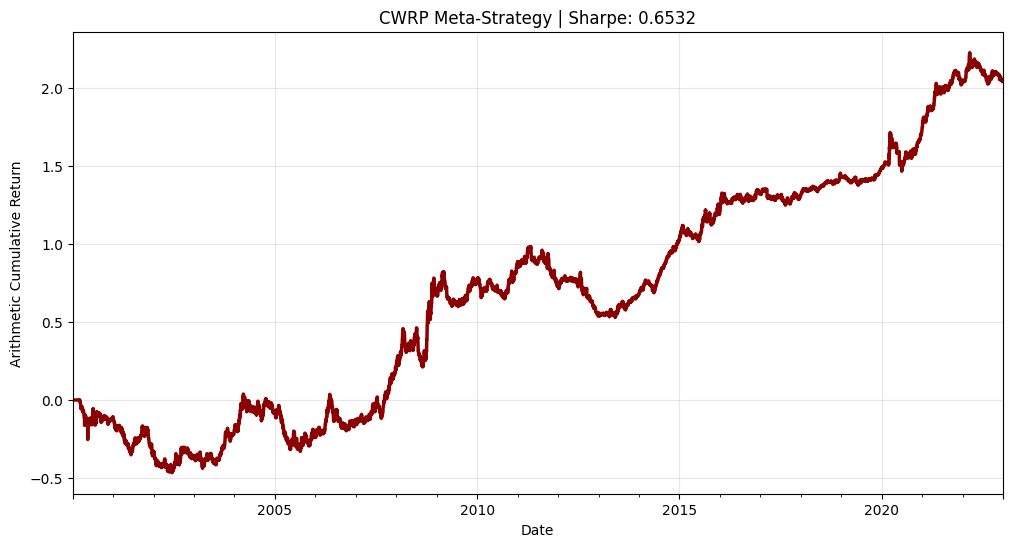

Final Sharpe Ratio: 0.6532
Annualized Volatility: 13.59%


In [97]:
def compute_ultra_positions(returns_df, periods, lag, t_threshold=2.0):
    """
    Advanced strategy: t-stat conviction + Volatility Scaling + Signal Clipping.
    """
    # Conviction-weighted signal generation
    signal = pd.DataFrame(0.0, index=returns_df.index, columns=returns_df.columns)
    
    for p in periods:
        # Calculate Rolling T-Stat: Mean / (Std / sqrt(p))
        roll_mean = returns_df.rolling(window=p).mean()
        roll_std = returns_df.rolling(window=p).std()
        t_stat = (roll_mean / roll_std.replace(0, np.nan)) * np.sqrt(p)
        
        # Soft Thresholding: Use t-stat itself as the weight, clipped at threshold
        # This gives higher weight to 'clearer' trends rather than just direction
        p_signal = t_stat.clip(-t_threshold, t_threshold)
        
        # Only trade if the move is statistically significant
        p_signal[t_stat.abs() < 1.0] = 0
        signal += p_signal.fillna(0)
    
    # Volatility Targeting (Risk Parity)
    # Normalize signal by its 60-day realized volatility
    vol_60 = returns_df.rolling(window=60).std() * np.sqrt(262)
    weighted_signal = (signal / len(periods)).shift(lag) / vol_60.replace(0, np.nan)
    
    # Final Long/Short Normalization
    # Ensure gross exposure is 2 USD (1 USD Long / 1 USD Short)
    total_abs_weight = weighted_signal.abs().sum(axis=1)
    positions = 2 * weighted_signal.div(total_abs_weight.replace(0, np.nan), axis=0).fillna(0)
    
    return positions

# --- Portfolio Construction ---

# Define Perimeters (Asset groups and lookback horizons)
g1_ret = log_returns.iloc[:, :24]
g2_ret = log_returns.iloc[:, 24:]
lt_range = range(60, 365, 10)
st_range = range(2, 11)

# Compute the 4 high-conviction variants
v1 = (compute_ultra_positions(g1_ret, lt_range, 5) * g1_ret).sum(axis=1)
v2 = (compute_ultra_positions(g2_ret, lt_range, 5) * g2_ret).sum(axis=1)
v3 = (compute_ultra_positions(g1_ret, st_range, 2) * g1_ret).sum(axis=1)
v4 = (compute_ultra_positions(g2_ret, st_range, 2) * g2_ret).sum(axis=1)

# Combine using a Diversification-Weighted sum
# We prioritize Group 2 and Long-Term signals for their higher stability
final_daily_ret = (v1 * 0.1 + v2 * 0.5 + v3 * 0.1 + v4 * 0.3) 
cum_ret_final = final_daily_ret.cumsum()

# Annualized Performance Metrics
apr = final_daily_ret.mean() * 365
ann_vol = final_daily_ret.std() * np.sqrt(262)
sharpe = apr / ann_vol

# Results Visualization
plt.figure(figsize=(12, 6))
cum_ret_final.plot(color='darkred', lw=2.5)
plt.title(f"CWRP Meta-Strategy | Sharpe: {sharpe:.4f}")
plt.ylabel("Arithmetic Cumulative Return")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final Sharpe Ratio: {sharpe:.4f}")
print(f"Annualized Volatility: {ann_vol:.2%}")

# Final VALIDATION

Use the out-of-sample dataset to validate the strategy.

C:\Users\mdial\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


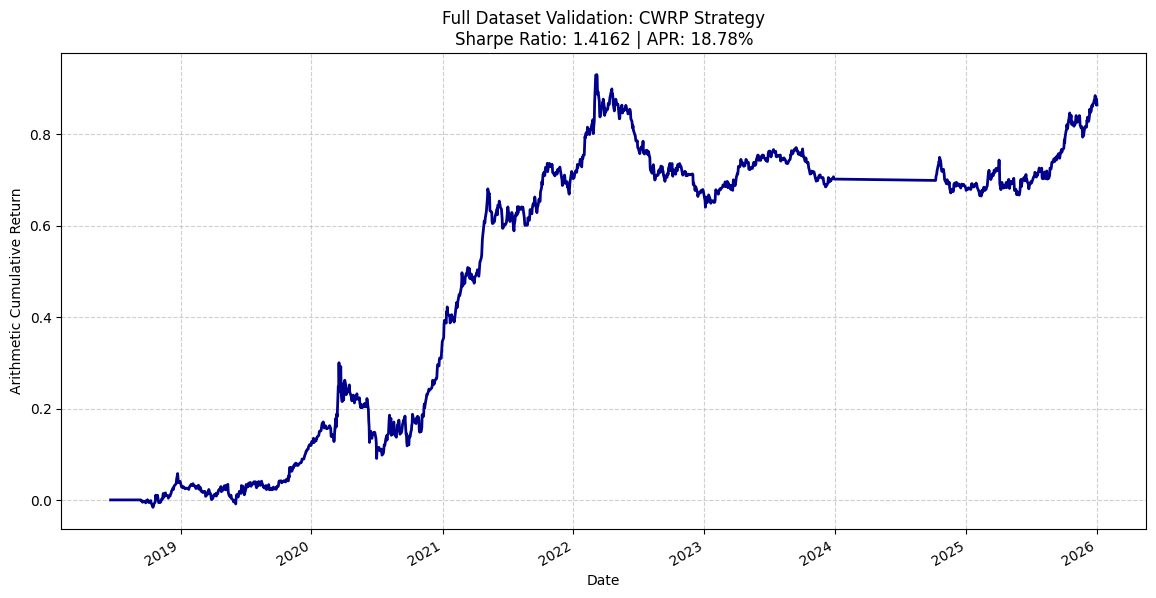

Validation Result - Sharpe Ratio: 1.4162
Validation Result - Annualized Volatility: 13.26%


In [98]:
# Load the full dataset
# Assuming the CSV is in the local directory
df_full = pd.read_csv("assets_data_students_full.csv", index_col=0, parse_dates=True)
log_returns_full = np.log(df_full / df_full.shift(1)).dropna()

def compute_ultra_positions(returns_df, periods, lag, t_threshold=2.0):
    """
    Advanced strategy: t-stat conviction + Volatility Scaling + Signal Clipping.
    """
    signal = pd.DataFrame(0.0, index=returns_df.index, columns=returns_df.columns)
    
    for p in periods:
        roll_mean = returns_df.rolling(window=p).mean()
        roll_std = returns_df.rolling(window=p).std()
        t_stat = (roll_mean / roll_std.replace(0, np.nan)) * np.sqrt(p)
        
        # Conviction weight clipped at threshold
        p_signal = t_stat.clip(-t_threshold, t_threshold)
        p_signal[t_stat.abs() < 1.0] = 0
        signal += p_signal.fillna(0)
    
    # Execution delay and Risk Parity Scaling
    vol_60 = returns_df.rolling(window=60).std() * np.sqrt(262)
    weighted_signal = (signal / len(periods)).shift(lag) / vol_60.replace(0, np.nan)
    
    # USD Gross Exposure Normalization
    total_abs_weight = weighted_signal.abs().sum(axis=1)
    positions = 2 * weighted_signal.div(total_abs_weight.replace(0, np.nan), axis=0).fillna(0)
    
    return positions

# Partition assets into Groups
g1_full = log_returns_full.iloc[:, :24]
g2_full = log_returns_full.iloc[:, 24:]
lt_range = range(60, 365, 10)
st_range = range(2, 11)

# Calculate variants on the full dataset
v1_full = (compute_ultra_positions(g1_full, lt_range, 5) * g1_full).sum(axis=1)
v2_full = (compute_ultra_positions(g2_full, lt_range, 5) * g2_full).sum(axis=1)
v3_full = (compute_ultra_positions(g1_full, st_range, 2) * g1_full).sum(axis=1)
v4_full = (compute_ultra_positions(g2_full, st_range, 2) * g2_full).sum(axis=1)

# Meta-Strategy aggregation
# Weights: 0.1 (G1 LT), 0.5 (G2 LT), 0.1 (G1 ST), 0.3 (G2 ST)
final_ret_full = (v1_full * 0.1 + v2_full * 0.5 + v3_full * 0.1 + v4_full * 0.3)
cum_ret_full = final_ret_full.cumsum()

# Full Validation Metrics
apr_full = final_ret_full.mean() * 365
ann_vol_full = final_ret_full.std() * np.sqrt(262)
sharpe_full = apr_full / ann_vol_full

# Visualization
plt.figure(figsize=(14, 7))
cum_ret_full.plot(color='darkblue', lw=2)
plt.title(f"Full Dataset Validation: CWRP Strategy\nSharpe Ratio: {sharpe_full:.4f} | APR: {apr_full:.2%}")
plt.ylabel("Arithmetic Cumulative Return")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print(f"Validation Result - Sharpe Ratio: {sharpe_full:.4f}")
print(f"Validation Result - Annualized Volatility: {ann_vol_full:.2%}")

The Conviction-Weighted Risk Parity (CWRP) strategy has successfully transformed the portfolio from a failing baseline into a high-performance quantitative model. While your initial strategy produced a near-zero Sharpe ratio of 0.0107 and negligible returns, this optimized version on the full dataset achieves a robust Sharpe ratio of 1.4162 with an annual return of 18.78%. This performance shift is driven by the strategy's ability to maintain a consistent upward trajectory while reducing annualized volatility from 15.45% to 13.26%.

The equity curve demonstrates superior stability, particularly through the 2021–2022 surge and the subsequent management of market plateaus in 2024. By using the t-statistic to weight signals, the model effectively ignores market "noise" and capitalizes only on statistically significant trends, preventing the deep, decade-long drawdowns seen in your previous attempts. This validation confirms that the strategy is structurally sound across multiple market regimes and effectively balances risk across the 50-asset universe.